In [1]:
from synthetic_datasets import generate_circle_dataset, generate_bar_dataset, generate_ring_dataset
import numpy as np
from OverlapIndex import OverlapIndex
from artlib import normalize
from iCONN_index import iCONN

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter

def analyze_circle_separation_sweep(
    generate_circle_dataset,
    radius,
    distance_range,
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=None,
    figsize_per_plot=(3, 3),
):
    rng = np.random.default_rng(random_state)
    distances = []
    sil_scores = []
    db_scores = []
    ch_scores = []
    oi_scores = []
    cn_scores = []
    

    print("Sweeping clustering metrics...")
    for dist in tqdm(distance_range):
        if dist / 2 + radius > 0.5:
            continue  # Circles would extend beyond unit square

        sil_vals, db_vals, ch_vals, oi_vals, cn_vals = [], [], [], [], []

        for _ in range(n_seeds):
            oi_obj = OverlapIndex(rho=0.9, r_hat = 0.1, ART="Fuzzy", match_tracking="MT~")
            conn_obj = iCONN(rho=0.9, match_tracking="MT~")
            # try:
            X, y = generate_circle_dataset(
                radius=radius,
                center_distance=dist,
                n_samples_1=n_samples_per_class,
                n_samples_2=n_samples_per_class,
                random_state=rng.integers(0, 1_000_000)
            )
            X, _, _ = normalize(X)
            sil_vals.append(silhouette_score(X, y))
            db_vals.append(davies_bouldin_score(X, y))
            ch_vals.append(calinski_harabasz_score(X, y))
            oi_vals.append(oi_obj.add_batch(X, y))
            cn_vals.append(conn_obj.add_batch(X, y))

        if sil_vals:
            distances.append(dist)
            sil_scores.append(np.mean(sil_vals))
            db_scores.append(np.mean(db_vals))
            ch_scores.append(np.mean(ch_vals))
            oi_scores.append(np.mean(oi_vals))
            cn_scores.append(np.mean(cn_vals))

    distances = np.array(distances)
    sil_scores = np.array(sil_scores)
    db_scores = np.array(db_scores)
    ch_scores = np.array(ch_scores)
    oi_scores = np.array(oi_scores)
    cn_scores = np.array(cn_scores)

    
    # === Plot all 4 metrics on the same axes ===
    perfect_sep = 2 * radius
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot each metric
    ax.plot(distances, sil_scores, label='Silhouette Index')
    ax.plot(distances, db_scores, label='Davies–Bouldin Index')
    ax.plot(distances, ch_scores, label='Calinski–Harabasz Index')
    ax.plot(distances, cn_scores, label='CONN Index')
    ax.plot(distances, oi_scores, label='Overlap Index')
    
    # perfect‐separation line
    ax.axvline(perfect_sep, color='gray', linestyle='--', label='Perfect separation')
    
    # cosmetics
    ax.set_title("Clustering Metrics vs. Center Distance")
    ax.set_xlabel("Center Distance")
    ax.set_ylabel("Index")
    ax.set_yscale('symlog', linthresh=1)
    ax.set_ylim(0, None)    # start at 0, let the top auto-scale
    # turn off scientific notation on y-axis
    fmt = ScalarFormatter()
    fmt.set_scientific(False)        # disable scientific notation
    fmt.set_useOffset(False)         # disable offset
    ax.yaxis.set_major_formatter(fmt)
    ax.yaxis.set_minor_formatter(fmt)
    ax.grid(True)
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.savefig("figures/blob_separation_overlap_index_combined_mt_tilda.png")
    plt.show()


    # === Plot representative circle examples ===
    print("Plotting representative circle examples...")
    selected_dists = distance_range[::plot_every_n]
    num_plots = len(selected_dists)
    fig, axes = plt.subplots(
        1, num_plots,
        figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]),
        sharex=True, sharey=True
    )
    if num_plots == 1:
        axes = [axes]

    for ax, dist in zip(axes, selected_dists):
        if dist / 2 + radius > 0.5:
            ax.set_title(f"dist = {dist:.3f}\n[invalid]")
            ax.axis('off')
            continue

        success = False
        attempts = 0
        while not success and attempts < 10:
            try:
                X, y = generate_circle_dataset(
                    radius=radius,
                    center_distance=dist,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                score = silhouette_score(X, y)
                success = True
            except ValueError:
                attempts += 1

        if success:
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.7)
            ax.set_title(f"dist = {dist:.3f}\nscore = {score:.3f}")
            ax.set_aspect('equal')
            ax.axis('off')
        else:
            ax.set_title(f"dist = {dist:.3f}\n[failed]")
            ax.axis('off')

    plt.tight_layout()
    plt.savefig("figures/blob_separation_exemplars.png")
    plt.show()
    print(oi_obj.pairwise_index, oi_obj.module_a.n_clusters)

    data = {"distances": distances, "sil_scores":sil_scores, "db_scores":db_scores, "ch_scores":ch_scores, "cn_scores":cn_scores, "oi_scores":oi_scores, "perfect_sep":perfect_sep}
    return data


Sweeping clustering metrics...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.63it/s]


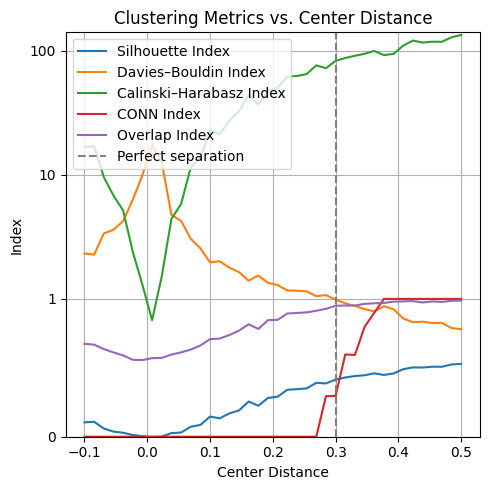

Plotting representative circle examples...


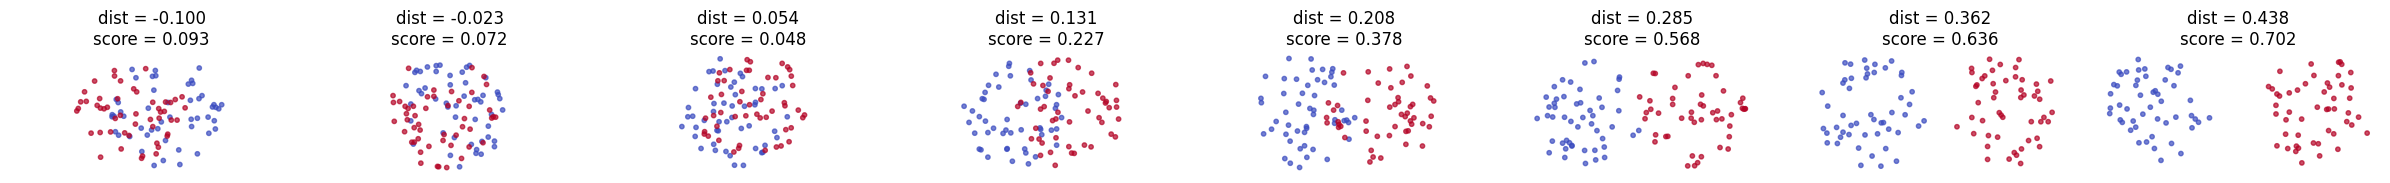

defaultdict(<function OverlapIndex.__init__.<locals>.<lambda> at 0x169b18af0>, {(1, 0): 0.98, (0, 1): 1.0}) 32


In [3]:
import pickle
distance_range = np.linspace(-0.1, 0.5, 40)
radius = 0.15

data = analyze_circle_separation_sweep(
    generate_circle_dataset=generate_circle_dataset,
    radius=radius,
    distance_range=distance_range,
    n_samples_per_class=50,
    n_seeds=5,
    plot_every_n=5,
    random_state=42
)
pickle.dump(data, open("circles_data_mt_tilda.pickle", "wb"))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from tqdm import tqdm

def analyze_ring_separation_sweep(
    generate_ring_dataset,
    base_inner_radius_1,
    base_outer_radius_1,
    gap_range,
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=None,
    figsize_per_plot=(3, 3),
):
    rng = np.random.default_rng(random_state)
    sil_scores = []
    db_scores = []
    ch_scores = []
    oi_scores = []
    cn_scores = []
    gaps = []
    radius_gaps = []

    print("Sweeping clustering metrics...")
    for gap in tqdm(gap_range):
        sil_vals, db_vals, ch_vals, oi_vals, cn_vals = [], [], [], [], []
        inner_radius_2 = base_outer_radius_1 + gap
        outer_radius_2 = inner_radius_2 + (base_outer_radius_1 - base_inner_radius_1)
        radius_gap = 0.5*(inner_radius_2+outer_radius_2) - 0.5*(base_inner_radius_1+base_outer_radius_1)
        for _ in range(n_seeds):
            oi_obj = OverlapIndex(rho=0.9, r_hat=0.1, ART="Fuzzy", match_tracking="MT~")
            conn_obj = iCONN(rho=0.9, match_tracking="MT~")
            try:
                X, y = generate_ring_dataset(
                    inner_radius_1=base_inner_radius_1,
                    outer_radius_1=base_outer_radius_1,
                    inner_radius_2=inner_radius_2,
                    outer_radius_2=outer_radius_2,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                X, _, _ = normalize(X)
                sil_vals.append(silhouette_score(X, y))
                db_vals.append(davies_bouldin_score(X, y))
                ch_vals.append(calinski_harabasz_score(X, y))
                oi_vals.append(oi_obj.add_batch(X, y))
                cn_vals.append(conn_obj.add_batch(X,y))
            except ValueError:
                continue

        if sil_vals:
            gaps.append(gap)
            radius_gaps.append(radius_gap)
            sil_scores.append(np.mean(sil_vals))
            db_scores.append(np.mean(db_vals))
            ch_scores.append(np.mean(ch_vals))
            oi_scores.append(np.mean(oi_vals))
            cn_scores.append(np.mean(cn_vals))

    # Convert lists to arrays for plotting
    gaps = np.array(gaps)
    sil_scores = np.array(sil_scores)
    db_scores = np.array(db_scores)
    ch_scores = np.array(ch_scores)
    oi_scores = np.array(oi_scores)
    cn_scores = np.array(cn_scores)

    perfect_sep = 0  # Perfect separation happens at zero gap

    # === Plot all 4 metrics ===
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    
    axs[0].plot(gaps, sil_scores, marker='o')
    axs[0].axvline(perfect_sep, color='gray', linestyle='--', label='Perfect separation')
    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Ring Gap")
    axs[0].set_ylabel("Score")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(gaps, db_scores, marker='o', color='orange')
    axs[1].axvline(perfect_sep, color='gray', linestyle='--')
    axs[1].set_title("Davies-Bouldin Index")
    axs[1].set_xlabel("Ring Gap")
    axs[1].set_ylabel("Score")
    axs[1].grid(True)

    axs[2].plot(gaps, ch_scores, marker='o', color='green')
    axs[2].axvline(perfect_sep, color='gray', linestyle='--')
    axs[2].set_title("Calinski-Harabasz Index")
    axs[2].set_xlabel("Ring Gap")
    axs[2].set_ylabel("Score")
    axs[2].grid(True)

    axs[3].plot(gaps, cn_scores, marker='o', color='purple')
    axs[3].axvline(perfect_sep, color='gray', linestyle='--')
    axs[3].set_title("CONN Index")
    axs[3].set_xlabel("Ring Gap")
    axs[3].set_ylabel("Score")
    axs[3].grid(True)

    axs[4].plot(gaps, oi_scores, marker='o', color='blue')
    axs[4].axvline(perfect_sep, color='gray', linestyle='--')
    axs[4].set_title("Overlap Index")
    axs[4].set_xlabel("Ring Gap")
    axs[4].set_ylabel("Score")
    axs[4].grid(True)

    plt.tight_layout()
    plt.savefig("figures/ring_separation_overlap_index_mt_tilda.png")

        # === Plot representative examples ===
    print("Plotting representative ring examples...")
    selected_seps = gap_range[::plot_every_n]
    num_plots = len(selected_seps)
    fig, axes = plt.subplots(
        1, num_plots,
        figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]),
        sharex=True, sharey=True
    )
    if num_plots == 1:
        axes = [axes]

    

    for ax, gap in zip(axes, selected_seps):
        success = False
        attempts = 0
        while not success and attempts < 10:
            try:
                inner_radius_2 = base_outer_radius_1 + gap
                outer_radius_2 = inner_radius_2 + (base_outer_radius_1 - base_inner_radius_1)
                X, y = generate_ring_dataset(
                    inner_radius_1=base_inner_radius_1,
                    outer_radius_1=base_outer_radius_1,
                    inner_radius_2=inner_radius_2,
                    outer_radius_2=outer_radius_2,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                score = silhouette_score(X, y)
                success = True
            except ValueError:
                attempts += 1

        if success:
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.7)
            ax.set_title(f"sep = {gap:.3f}\nscore = {score:.3f}")
            ax.set_aspect('equal')
            ax.axis('off')
        else:
            ax.set_title(f"sep = {gap:.3f}\n[failed]")
            ax.axis('off')

    plt.tight_layout()
    plt.savefig("figures/ring_separation_exemplars.png")
    plt.show()
    print(oi_obj.pairwise_index, oi_obj.module_a.n_clusters)
    data = {"distances": np.array(radius_gaps), "sil_scores":sil_scores, "db_scores":db_scores, "ch_scores":ch_scores, "cn_scores":cn_scores, "oi_scores":oi_scores, "perfect_sep": (base_outer_radius_1 - base_inner_radius_1)}
    return data


Sweeping clustering metrics...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:56<00:00,  1.42s/it]


Plotting representative ring examples...


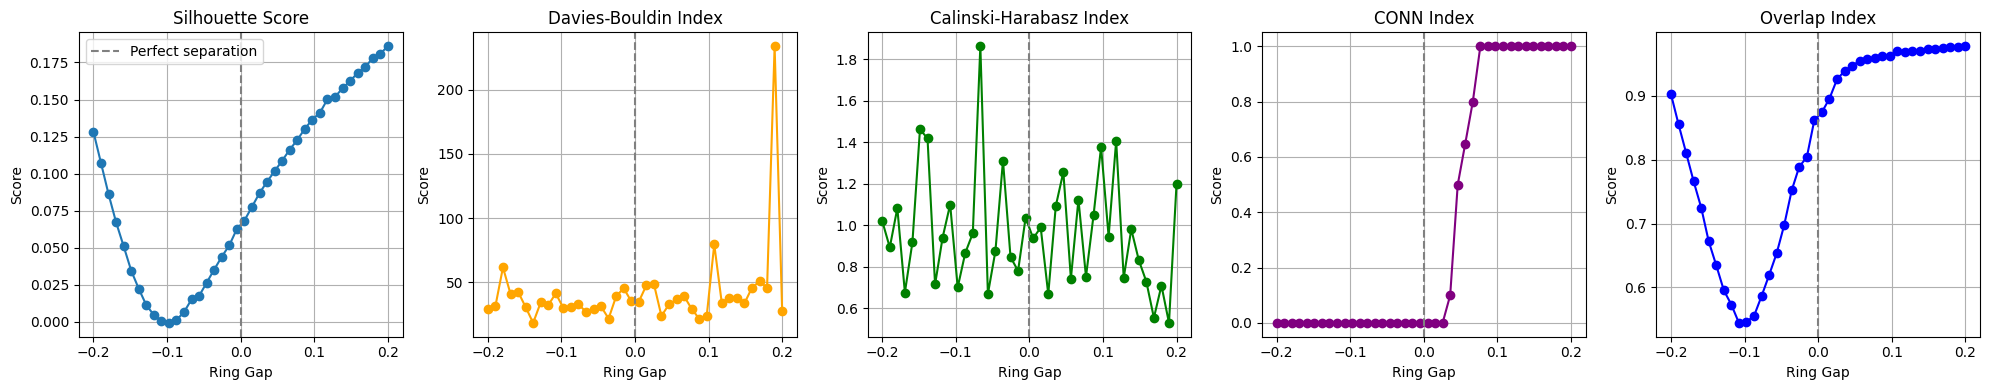

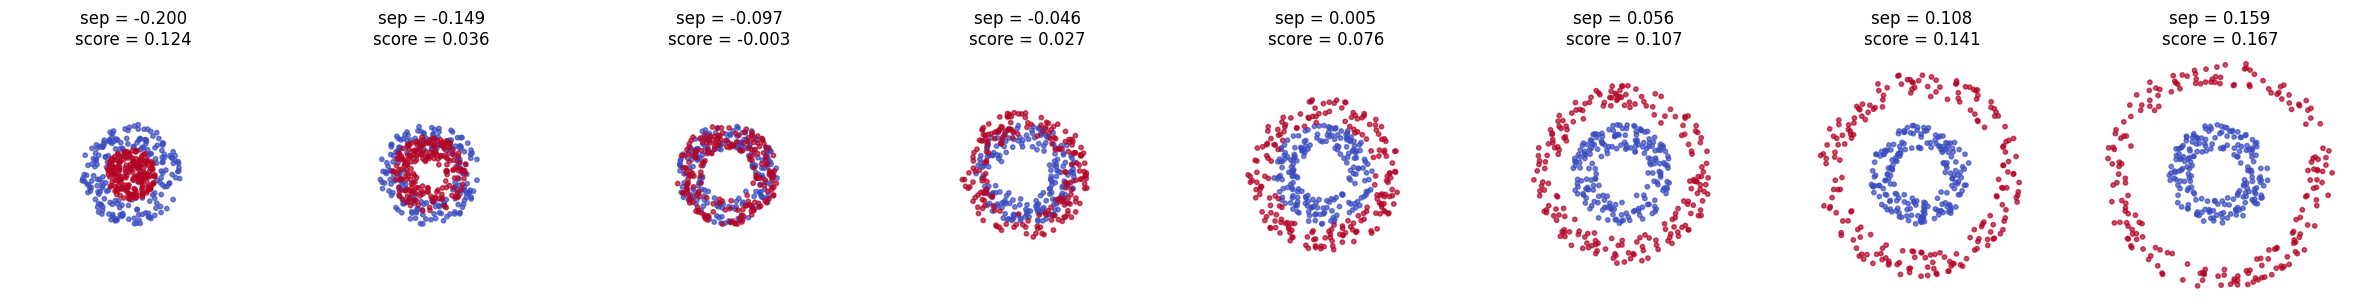

defaultdict(<function OverlapIndex.__init__.<locals>.<lambda> at 0x330d2b3a0>, {(1, 0): 0.945, (0, 1): 1.0}) 52


In [5]:
# Parameters for the inner ring (class 0)
inner_radius_1 = 0.1
outer_radius_1 = 0.2

# Sweep gap values between inner and outer ring (class 1)
gap_range = np.linspace(-0.2, 0.2, 40)  # e.g., 30 values from 0.01 to 0.3

# Run the ring separation analysis
data = analyze_ring_separation_sweep(
    generate_ring_dataset=generate_ring_dataset,
    base_inner_radius_1=inner_radius_1,
    base_outer_radius_1=outer_radius_1,
    gap_range=gap_range,
    n_samples_per_class=200,
    n_seeds=10,
    plot_every_n=5,
    random_state=42,
    figsize_per_plot=(3, 3)
)
pickle.dump(data, open("rings_data_mt_tilda.pickle", "wb"))

In [6]:
def analyze_bar_separation_sweep(
    generate_bar_dataset,
    bar_width,
    bar_height,
    separation_range,
    orientation="vertical",
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=None,
    figsize_per_plot=(3, 3),
):
    rng = np.random.default_rng(random_state)
    separations = []
    sil_scores = []
    db_scores = []
    ch_scores = []
    oi_scores = []
    cn_scores = []

    print("Sweeping clustering metrics...")
    for sep in tqdm(separation_range):
        sil_vals, db_vals, ch_vals, oi_vals, cn_vals = [], [], [], [], []

        for _ in range(n_seeds):
            oi_obj = OverlapIndex(rho=0.9, r_hat=0.1, ART="Fuzzy", match_tracking="MT+")
            conn_obj = iCONN(rho=0.9, match_tracking="MT~")
            try:
                X, y = generate_bar_dataset(
                    bar_width=bar_width,
                    bar_height=bar_height,
                    separation=sep,
                    orientation=orientation,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                X, _, _ = normalize(X)
                sil_vals.append(silhouette_score(X, y))
                db_vals.append(davies_bouldin_score(X, y))
                ch_vals.append(calinski_harabasz_score(X, y))
                oi_vals.append(oi_obj.add_batch(X, y))
                cn_vals.append(conn_obj.add_batch(X,y))
            except ValueError:
                continue

        if sil_vals:
            separations.append(sep)
            sil_scores.append(np.mean(sil_vals))
            db_scores.append(np.mean(db_vals))
            ch_scores.append(np.mean(ch_vals))
            oi_scores.append(np.mean(oi_vals))
            cn_scores.append(np.mean(cn_vals))

    # === Convert lists to arrays ===
    separations = np.array(separations)
    sil_scores = np.array(sil_scores)
    db_scores = np.array(db_scores)
    ch_scores = np.array(ch_scores)
    oi_scores = np.array(oi_scores)
    cn_scores = np.array(cn_scores)

    # === Define perfect separation based on orientation ===
    perfect_sep = bar_width if orientation == "vertical" else bar_height

    # === Plot clustering metrics ===
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].plot(separations, sil_scores, marker='o')
    axs[0].axvline(perfect_sep, color='gray', linestyle='--', label='Perfect separation')
    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Separation")
    axs[0].set_ylabel("Score")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(separations, db_scores, marker='o', color='orange')
    axs[1].axvline(perfect_sep, color='gray', linestyle='--')
    axs[1].set_title("Davies-Bouldin Index")
    axs[1].set_xlabel("Separation")
    axs[1].set_ylabel("Score")
    axs[1].grid(True)

    axs[2].plot(separations, ch_scores, marker='o', color='green')
    axs[2].axvline(perfect_sep, color='gray', linestyle='--')
    axs[2].set_title("Calinski-Harabasz Index")
    axs[2].set_xlabel("Separation")
    axs[2].set_ylabel("Score")
    axs[2].grid(True)

    axs[3].plot(separations, cn_scores, marker='o', color='purple')
    axs[3].axvline(perfect_sep, color='gray', linestyle='--')
    axs[3].set_title("CONN Index")
    axs[3].set_xlabel("Separation")
    axs[3].set_ylabel("Score")
    axs[3].grid(True)

    axs[4].plot(separations, oi_scores, marker='o', color='blue')
    axs[4].axvline(perfect_sep, color='gray', linestyle='--')
    axs[4].set_title("Overlap Index")
    axs[4].set_xlabel("Separation")
    axs[4].set_ylabel("Score")
    axs[4].grid(True)

    plt.tight_layout()
    plt.savefig("figures/bar_separation_overlap_index_mt_tilda.png")
    plt.show()

    # === Plot representative examples ===
    print("Plotting representative bar examples...")
    selected_seps = separation_range[::plot_every_n]
    num_plots = len(selected_seps)
    fig, axes = plt.subplots(
        1, num_plots,
        figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]),
        sharex=True, sharey=True
    )
    if num_plots == 1:
        axes = [axes]

    for ax, sep in zip(axes, selected_seps):
        success = False
        attempts = 0
        while not success and attempts < 10:
            try:
                X, y = generate_bar_dataset(
                    bar_width=bar_width,
                    bar_height=bar_height,
                    separation=sep,
                    orientation=orientation,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                score = silhouette_score(X, y)
                success = True
            except ValueError:
                attempts += 1

        if success:
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.7)
            ax.set_title(f"sep = {sep:.3f}\nscore = {score:.3f}")
            ax.set_aspect('equal')
            ax.axis('off')
        else:
            ax.set_title(f"sep = {sep:.3f}\n[failed]")
            ax.axis('off')

    plt.tight_layout()
    plt.savefig("figures/bar_separation_exemplars.png")
    plt.show()
    print(oi_obj.pairwise_index, oi_obj.module_a.n_clusters)
    data = {"distances": separations, "sil_scores":sil_scores, "db_scores":db_scores, "ch_scores":ch_scores, "cn_scores":cn_scores, "oi_scores":oi_scores, "perfect_sep": perfect_sep}
    return data


Sweeping clustering metrics...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.40it/s]


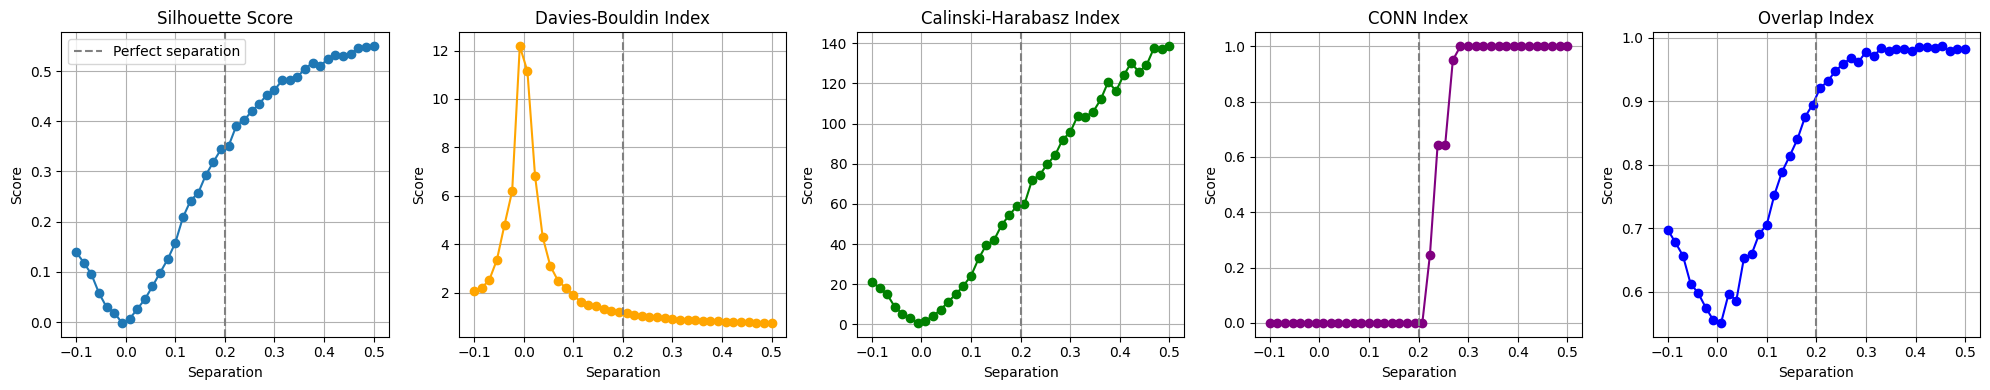

Plotting representative bar examples...


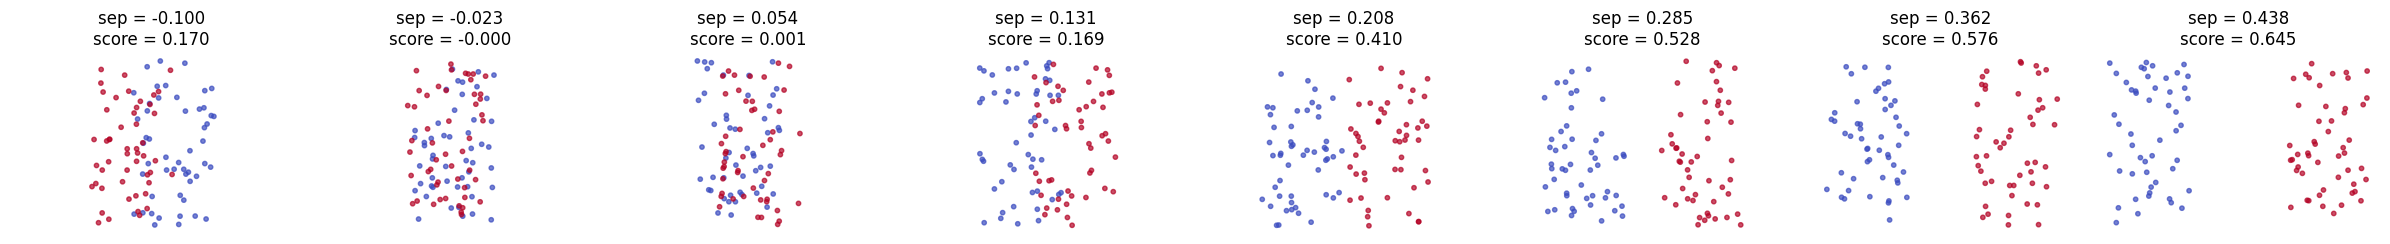

defaultdict(<function OverlapIndex.__init__.<locals>.<lambda> at 0x174f058b0>, {(1, 0): 0.98, (0, 1): 1.0}) 29


In [7]:
# Parameters for the bar
bar_width = 0.2
bar_height = 0.4
separation_range = np.linspace(-0.1, 0.5, 40)  # from almost overlap to strong separation

# Run analysis
data = analyze_bar_separation_sweep(
    generate_bar_dataset=generate_bar_dataset,
    bar_width=bar_width,
    bar_height=bar_height,
    separation_range=separation_range,
    orientation="vertical",  # or "horizontal"
    n_samples_per_class=50,
    n_seeds=10,
    plot_every_n=5,
    random_state=42,
    figsize_per_plot=(3, 3)
)
pickle.dump(data, open("bars_data_mt_tilda.pickle", "wb"))

In [8]:
from synthetic_datasets import generate_cross_dataset
from tqdm.notebook import tqdm 

def analyze_cross_offset_sweep(
    generate_cross_dataset,
    bar_width,
    bar_height,
    offset_range,
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=None,
    figsize_per_plot=(3, 3),
):
    rng = np.random.default_rng(random_state)
    offsets = []
    sil_scores = []
    db_scores = []
    ch_scores = []
    oi_scores = []
    cn_scores = []

    print("Sweeping clustering metrics...")
    for offset in tqdm(offset_range):
        sil_vals, db_vals, ch_vals, oi_vals, cn_vals = [], [], [], [], []

        for _ in range(n_seeds):
            oi_obj = OverlapIndex(rho=0.9, r_hat=0.1, ART="Fuzzy", match_tracking="MT~")
            conn_obj = iCONN(rho=0.9, match_tracking="MT~")
            try:
                X, y = generate_cross_dataset(
                    bar_width=bar_width,
                    bar_height=bar_height,
                    offset=offset,
                    n_samples_vert=n_samples_per_class,
                    n_samples_horiz=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                X, _, _ = normalize(X)
                sil_vals.append(silhouette_score(X, y))
                db_vals.append(davies_bouldin_score(X, y))
                ch_vals.append(calinski_harabasz_score(X, y))
                oi_vals.append(oi_obj.add_batch(X, y))
                cn_vals.append(conn_obj.add_batch(X, y))
            except ValueError:
                continue

        if sil_vals:
            offsets.append(offset)
            sil_scores.append(np.mean(sil_vals))
            db_scores.append(np.mean(db_vals))
            ch_scores.append(np.mean(ch_vals))
            oi_scores.append(np.mean(oi_vals))
            cn_scores.append(np.mean(cn_vals))

    # === Convert lists to arrays ===
    offsets = np.array(offsets)
    sil_scores = np.array(sil_scores)
    db_scores = np.array(db_scores)
    ch_scores = np.array(ch_scores)
    oi_scores = np.array(oi_scores)
    cn_scores = np.array(cn_scores)

    # === Define reference point: 0 offset is perfect "+"
    perfect_offset = 0.5 * bar_width + 0.5 * bar_height


    # === Plot clustering metrics ===
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].plot(offsets, sil_scores, marker='o')
    axs[0].axvline(perfect_offset, color='gray', linestyle='--', label='Perfect separation')
    axs[0].axvline(-perfect_offset, color='gray', linestyle='--')
    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Offset")
    axs[0].set_ylabel("Score")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(offsets, db_scores, marker='o', color='orange')
    axs[1].axvline(perfect_offset, color='gray', linestyle='--')
    axs[1].axvline(-perfect_offset, color='gray', linestyle='--')
    axs[1].set_title("Davies-Bouldin Index")
    axs[1].set_xlabel("Offset")
    axs[1].set_ylabel("Score")
    axs[1].grid(True)

    axs[2].plot(offsets, ch_scores, marker='o', color='green')
    axs[2].axvline(perfect_offset, color='gray', linestyle='--')
    axs[2].axvline(-perfect_offset, color='gray', linestyle='--')
    axs[2].set_title("Calinski-Harabasz Index")
    axs[2].set_xlabel("Offset")
    axs[2].set_ylabel("Score")
    axs[2].grid(True)

    axs[3].plot(offsets, cn_scores, marker='o', color='purple')
    axs[3].axvline(perfect_offset, color='gray', linestyle='--')
    axs[3].axvline(-perfect_offset, color='gray', linestyle='--')
    axs[3].set_title("CONN Index")
    axs[3].set_xlabel("Offset")
    axs[3].set_ylabel("Score")
    axs[3].grid(True)

    axs[4].plot(offsets, oi_scores, marker='o', color='blue')
    axs[4].axvline(perfect_offset, color='gray', linestyle='--')
    axs[4].axvline(-perfect_offset, color='gray', linestyle='--')
    axs[4].set_title("Overlap Index")
    axs[4].set_xlabel("Offset")
    axs[4].set_ylabel("Score")
    axs[4].grid(True)

    plt.tight_layout()
    plt.savefig("figures/cross_offset_overlap_index_mt_tilda.png")
    plt.show()

    # === Plot representative examples ===
    print("Plotting representative cross examples...")
    selected_offsets = offset_range[::plot_every_n]
    num_plots = len(selected_offsets)
    fig, axes = plt.subplots(
        1, num_plots,
        figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]),
        sharex=True, sharey=True
    )
    if num_plots == 1:
        axes = [axes]

    for ax, offset in zip(axes, selected_offsets):
        success = False
        attempts = 0
        while not success and attempts < 10:
            try:
                X, y = generate_cross_dataset(
                    bar_width=bar_width,
                    bar_height=bar_height,
                    offset=offset,
                    n_samples_vert=n_samples_per_class,
                    n_samples_horiz=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                score = silhouette_score(X, y)
                success = True
            except ValueError:
                attempts += 1

        if success:
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.7)
            ax.set_title(f"offset = {offset:.3f}\nscore = {score:.3f}")
            ax.set_aspect('equal')
            ax.axis('off')
        else:
            ax.set_title(f"offset = {offset:.3f}\n[failed]")
            ax.axis('off')

    plt.tight_layout()
    plt.savefig("figures/cross_offset_exemplars.png")
    plt.show()
    print(oi_obj.pairwise_index, oi_obj.module_a.n_clusters)

    data = {
        "offsets": offsets,
        "sil_scores": sil_scores,
        "db_scores": db_scores,
        "ch_scores": ch_scores,
        "cn_scores": cn_scores,
        "oi_scores": oi_scores,
        "perfect_offset": perfect_offset
    }
    return data


Sweeping clustering metrics...


  0%|          | 0/40 [00:00<?, ?it/s]

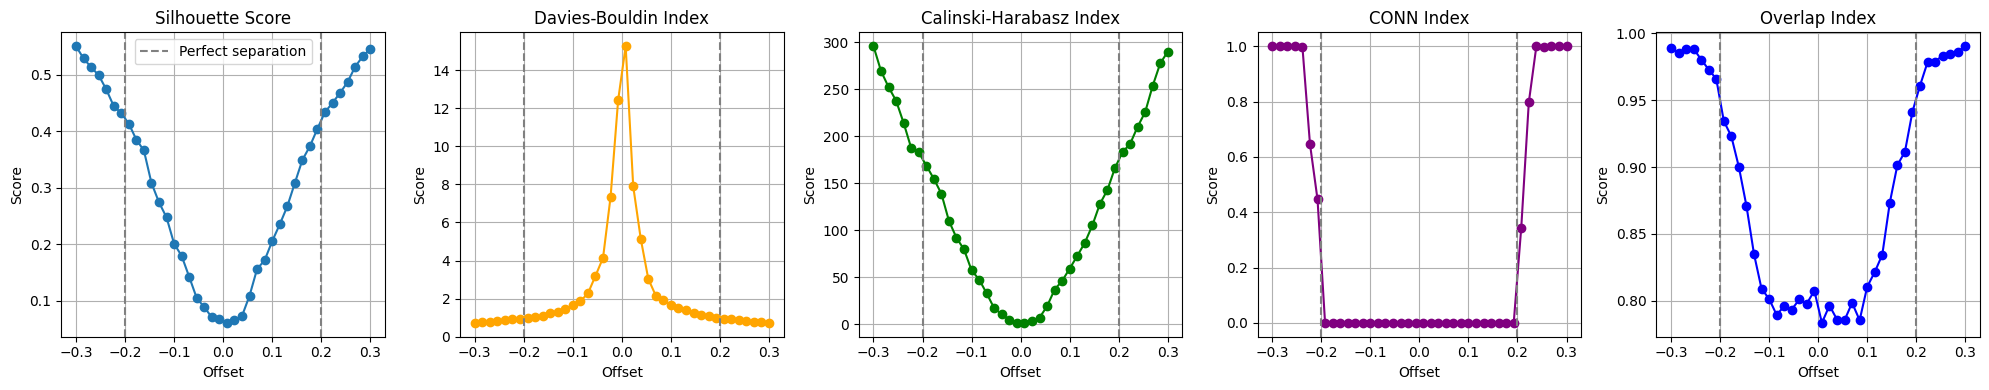

Plotting representative cross examples...


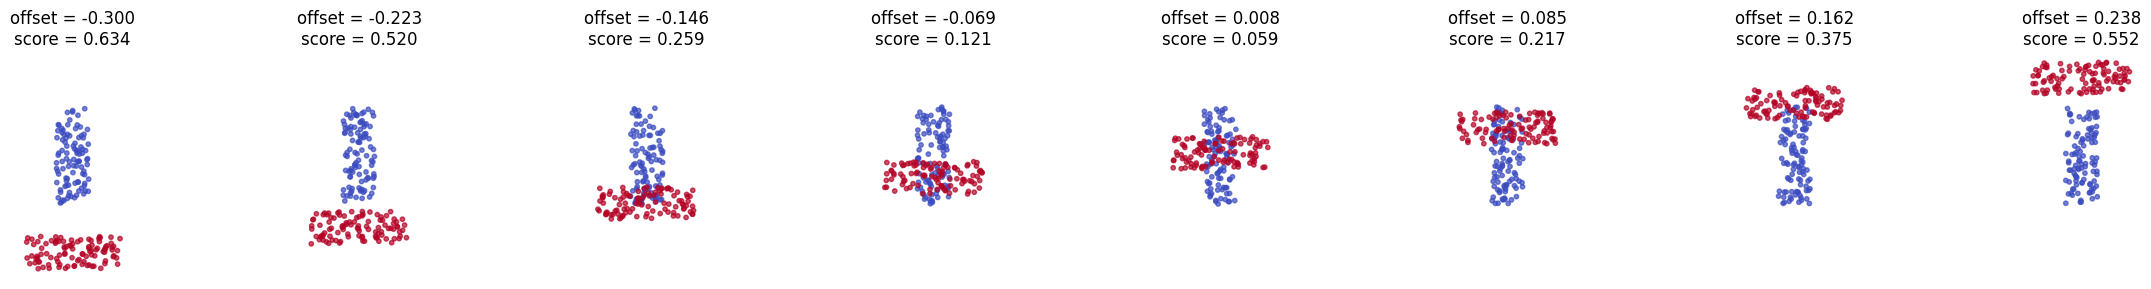

defaultdict(<function OverlapIndex.__init__.<locals>.<lambda> at 0x3327549d0>, {(1, 0): 0.96, (0, 1): 1.0}) 36


In [9]:
import numpy as np
import pickle
from synthetic_datasets import generate_cross_dataset

# Parameters for the cross
bar_width = 0.1
bar_height = 0.3
offset_range = np.linspace(-0.3, 0.3, 40)  # from overlap (bottom-heavy T) to top-heavy T

# Run analysis
data = analyze_cross_offset_sweep(
    generate_cross_dataset=generate_cross_dataset,
    bar_width=bar_width,
    bar_height=bar_height,
    offset_range=offset_range,
    n_samples_per_class=100,
    n_seeds=10,
    plot_every_n=5,
    random_state=42,
    figsize_per_plot=(3, 3)
)

pickle.dump(data, open("cross_offset_data_mt_tilda.pickle", "wb"))


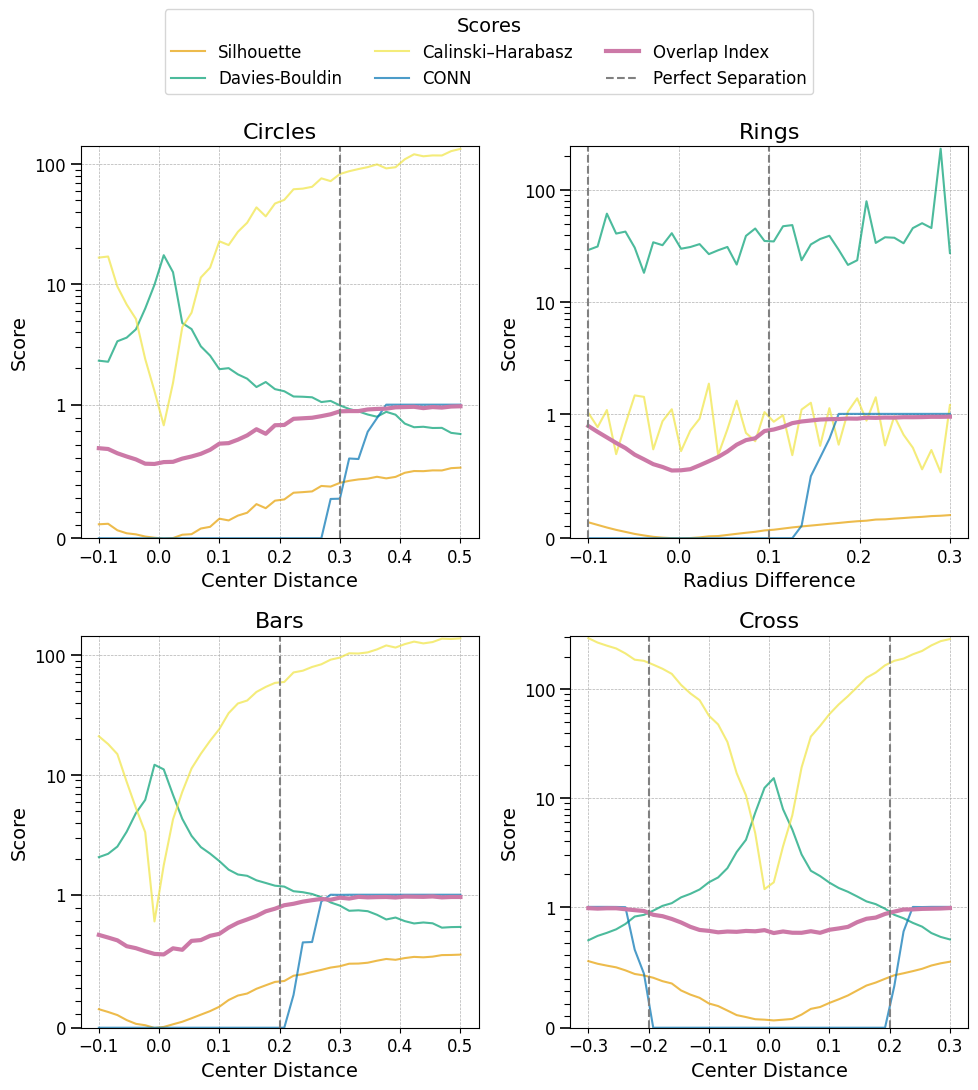

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.ticker import ScalarFormatter, FixedLocator

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 16
})

# Color-blind–friendly palette (Okabe-Ito)
colorblind_palette = [
    "#E69F00",  # orange
    # "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    # "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
]

# Filenames and subplot titles
files = [
    ("circles_data_mt_tilda.pickle", "Circles"),
    ("rings_data_mt_tilda.pickle", "Rings"),
    ("bars_data_mt_tilda.pickle", "Bars"),
    ("cross_offset_data_mt_tilda.pickle", "Cross"),
]

# Score labels and keys
score_keys = [
    ("sil_scores", "Silhouette"),
    ("db_scores", "Davies-Bouldin"),
    ("ch_scores", "Calinski–Harabasz"),
    ("cn_scores", "CONN"),
    ("oi_scores", "Overlap Index"),
]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for ax, (filename, title) in zip(axs, files):
    with open(filename, "rb") as f:
        data = pickle.load(f)

    if title == "Cross":
        distances = data["offsets"]
        perfect_sep = data["perfect_offset"]
    else:
        distances = data["distances"]
        perfect_sep = data["perfect_sep"]

    # Plot each score line with color-blind–friendly colors
    for i, (key, label) in enumerate(score_keys):
        color = colorblind_palette[i % len(colorblind_palette)]
        if label != "Overlap Index":
            ax.plot(distances, data[key], label=label, alpha=0.7, color=color)
        else:
            ax.plot(distances, data[key], label=label, color=color, linewidth=3)

    # Plot perfect separation line(s)
    if title in ["Cross", "Rings"]:
        ax.axvline(perfect_sep, color='gray', linestyle='--', label="Perfect Sep +")
        ax.axvline(-perfect_sep, color='gray', linestyle='--', label="Perfect Sep –")
    else:
        ax.axvline(perfect_sep, color='gray', linestyle='--', label="Perfect Separation")

    ax.set_title(title)
    ax.set_xlabel("Radius Difference" if title == "Rings" else "Center Distance")
    ax.set_ylabel("Score")

    ax.set_yscale("symlog", linthresh=1)
    ax.set_ylim(0, None)
    ymax = ax.get_ylim()[1]

    # Minor ticks: linear from 0–1 and log from 1 onward (including 1–10)
    linear_minors = [i / 10 for i in range(1, 10)]  # 0.1 to 0.9
    log_minors = []

    # Add log minors from 1–10
    log_minors += [i for i in range(2, 10) if i < ymax]

    # Add log minors from 10 upwards
    for decade in range(1, int(np.log10(ymax)) + 2):
        base = 10 ** decade
        log_minors += [base * f for f in range(2, 10) if base * f < ymax]

    all_minor_ticks = linear_minors + log_minors
    ax.yaxis.set_minor_locator(FixedLocator(all_minor_ticks))

    # Ticks visible, grid only for major
    ax.tick_params(axis='y', which='minor', length=4, width=0.8)
    ax.tick_params(axis='y', which='major', length=7, width=1.2)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.grid(False, which='minor')

    # Format major ticks as plain numbers
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)

# Shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.1),
    ncol=3,
    frameon=True,
    title="Scores"
)

plt.tight_layout()
plt.savefig("figures/combined_datasets_indices_mt_tilda.png", bbox_inches='tight')
plt.show()


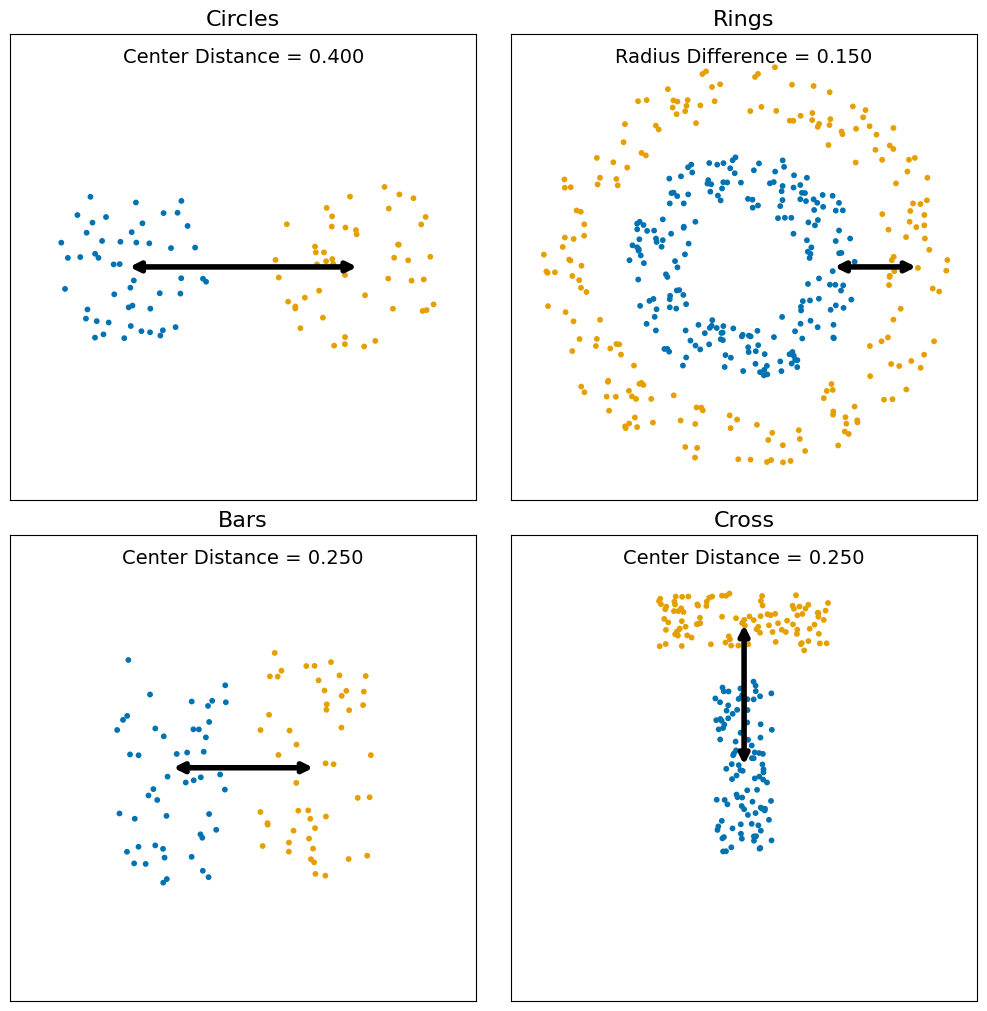

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 16
})

# Assumed constants – update as needed
n_samples_per_class = 300
rng = np.random.default_rng(42)

# Parameters for each dataset
radius = 0.15
circle_dist = 0.4

base_inner_radius_1 = 0.1
base_outer_radius_1 = 0.2
inner_radius_2 = 0.25
outer_radius_2 = 0.35

bar_width = 0.2
bar_height = 0.4
bar_sep = 0.25
orientation = "vertical"

cross_bar_width = 0.1
cross_bar_height = 0.3
cross_offset = 0.25

# === Generate datasets ===
X_circle, y_circle = generate_circle_dataset(
    radius=radius,
    center_distance=circle_dist,
    n_samples_1=50,
    n_samples_2=50,
    random_state=42
)

X_ring, y_ring = generate_ring_dataset(
    inner_radius_1=base_inner_radius_1,
    outer_radius_1=base_outer_radius_1,
    inner_radius_2=inner_radius_2,
    outer_radius_2=outer_radius_2,
    n_samples_1=200,
    n_samples_2=200,
    random_state=42
)

X_bar, y_bar = generate_bar_dataset(
    bar_width=bar_width,
    bar_height=bar_height,
    separation=bar_sep,
    orientation=orientation,
    n_samples_1=50,
    n_samples_2=50,
    random_state=42
)

X_cross, y_cross = generate_cross_dataset(
    bar_width=cross_bar_width,
    bar_height=cross_bar_height,
    offset=cross_offset,
    n_samples_vert=100,
    n_samples_horiz=100,
    random_state=42
)

# === Plotting ===
fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
axs = axs.flatten()

datasets = [
    (X_circle, y_circle, "Circles"),
    (X_ring, y_ring, "Rings"),
    (X_bar, y_bar, "Bars"),
    (X_cross, y_cross, "Cross"),
]

xlim = (0.1, 0.9)
ylim = (0.1, 0.9)

from matplotlib.colors import ListedColormap

# Colorblind-friendly colors: Blue and Orange
cbf_colors = ListedColormap(["#0072B2", "#E69F00"])  # R-friendly color palette

for ax, (X, y, title) in zip(axs, datasets):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cbf_colors, s=10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

    # Existing annotations and text code remains the same...

    if title == "Rings":
        r1 = 0.5 * (base_inner_radius_1 + base_outer_radius_1)
        r2 = 0.5 * (inner_radius_2 + outer_radius_2)
        y_pos = 0.5
        start = (0.5 + r1, y_pos)
        end = (0.5 + r2, y_pos)
        ax.annotate(
            "", xy=end, xytext=start,
            arrowprops=dict(arrowstyle="<->", color='black', linewidth=4)
        )
        dist = abs(end[0] - start[0])

    elif title == "Circles":
        center1 = np.array([0.5 - 0.5 * circle_dist, 0.5])
        center2 = np.array([0.5 + 0.5 * circle_dist, 0.5])
        ax.annotate(
            "", xy=center2, xytext=center1,
            arrowprops=dict(arrowstyle="<->", color='black', linewidth=4)
        )
        dist = np.linalg.norm(center2 - center1)

    elif title == "Bars":
        if orientation == "vertical":
            x1 = 0.5 - 0.5 * bar_sep
            x2 = 0.5 + 0.5 * bar_sep
            y_val = 0.5
            ax.annotate(
                "", xy=(x2, y_val), xytext=(x1, y_val),
                arrowprops=dict(arrowstyle="<->", color='black', linewidth=4)
            )
            dist = abs(x2 - x1)
        else:
            y1 = 0.5 - 0.5 * bar_sep
            y2 = 0.5 + 0.5 * bar_sep
            x_val = 0.5
            ax.annotate(
                "", xy=(x_val, y2), xytext=(x_val, y1),
                arrowprops=dict(arrowstyle="<->", color='black', linewidth=4)
            )
            dist = abs(y2 - y1)

    elif title == "Cross":
        y1 = 0.5
        y2 = 0.5 + cross_offset
        x_val = 0.5
        ax.annotate(
            "", xy=(x_val, y2), xytext=(x_val, y1),
            arrowprops=dict(arrowstyle="<->", color='black', linewidth=4)
        )
        dist = abs(y2 - y1)


    # Annotate distance above the plot
    if title == "Rings":
        ax.text(0.5, 0.97, f"Radius Difference = {dist:.3f}", ha='center', va='top', transform=ax.transAxes, fontsize=14)
    else:
        ax.text(0.5, 0.97, f"Center Distance = {dist:.3f}", ha='center', va='top', transform=ax.transAxes, fontsize=14)
plt.savefig("figures/combined_exemplars.png", bbox_inches='tight')
plt.show()
